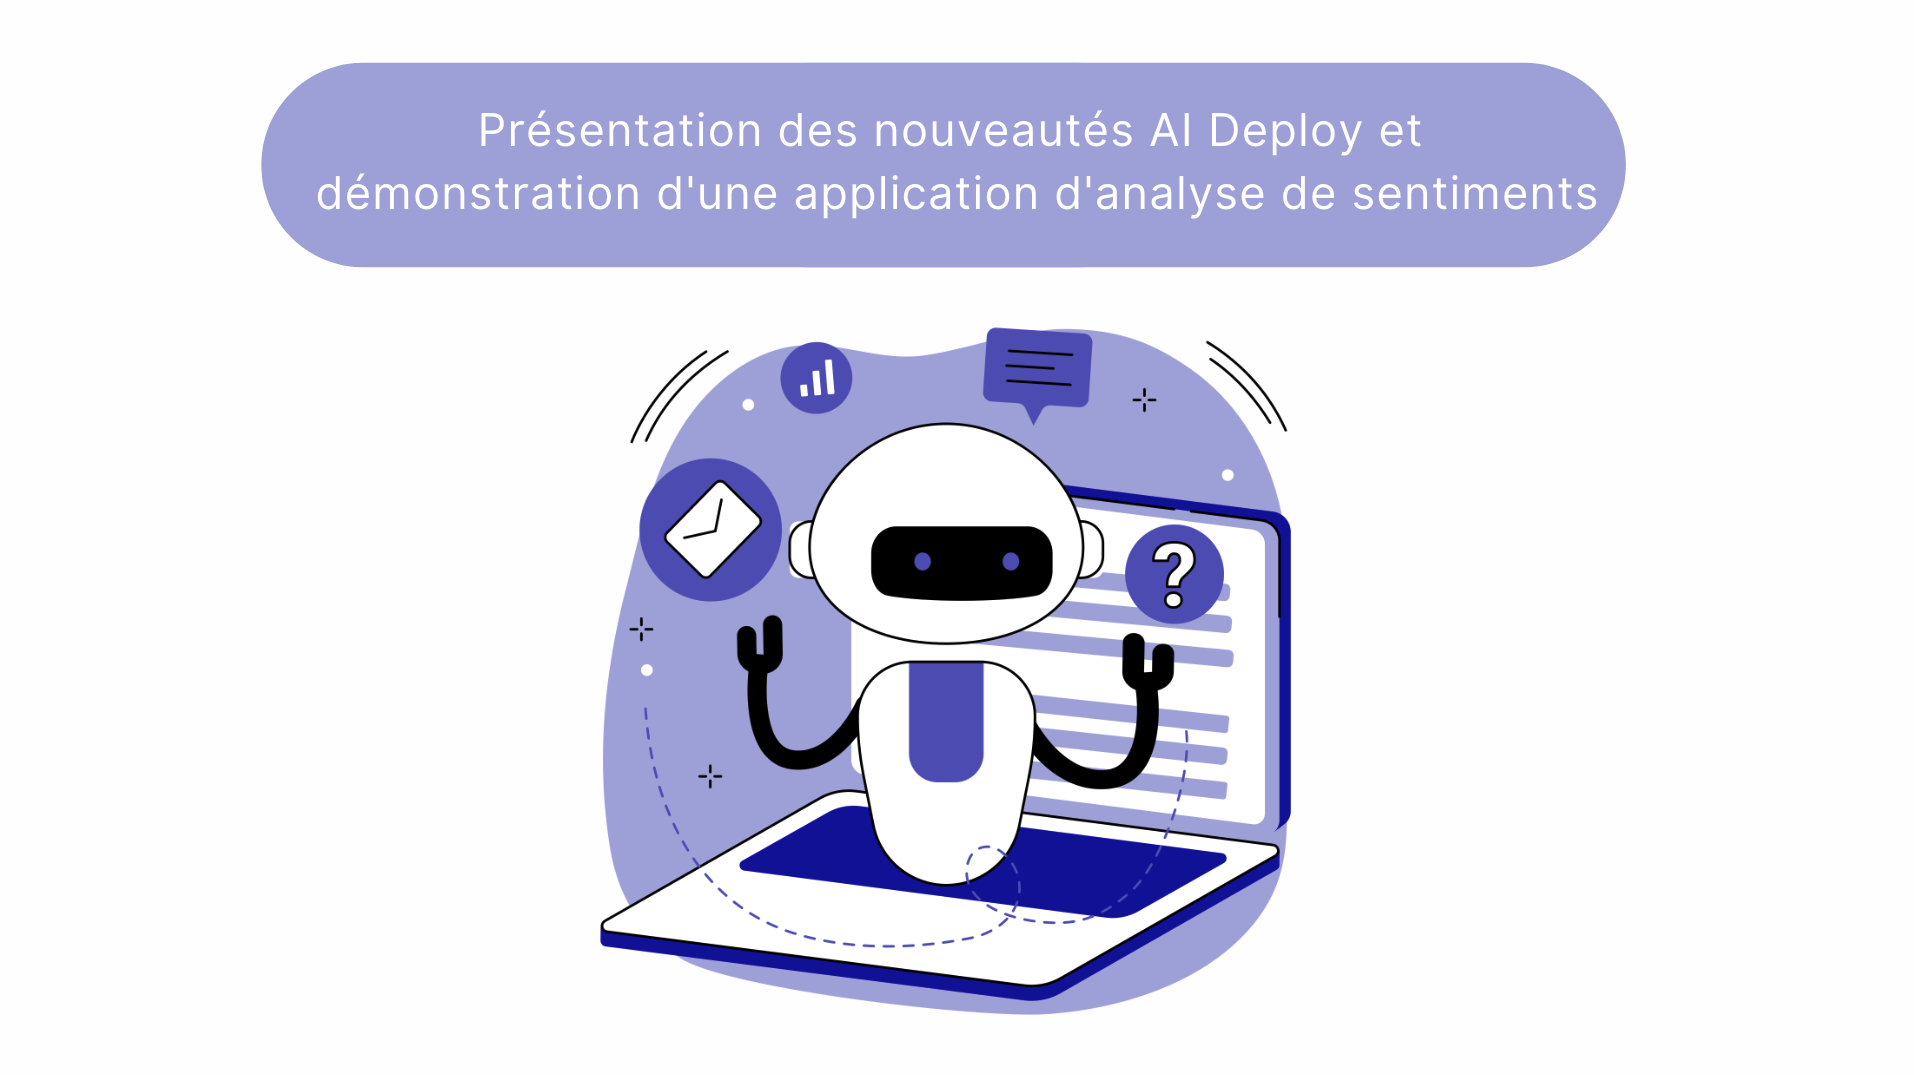

### CAS D'USAGE : Tweets français concernant OVHcloud 

- modèle pré-entraîné [Hugging Face](https://huggingface.co/) basé sur [camemBERT](https://huggingface.co/transformers/model_doc/camembert.html) 
- modèle optimisé pour l'analyse de sentiments : [pt-tblard-tf-allocine](https://huggingface.co/philschmid/pt-tblard-tf-allocine).

### Etape 1 - Installation et importation des dépendances Python

In [ ]:
# install the 'requirements.txt' file
!pip install -r requirements.txt

In [1]:
#import dependencies
import transformers
import pandas as pd
import re
import torch
import matplotlib.pyplot as plt

In [2]:
# check GPU availability
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.6.0 _CudaDeviceProperties(name='Tesla V100S-PCIE-32GB', major=7, minor=0, total_memory=32510MB, multi_processor_count=80)


### Etape 2 - Chargement du jeu de données de Tweets

In [3]:
dataframe = pd.read_csv("/workspace/data/tweet_2021-10-16.csv",sep = ',')

# display the first row
dataframe.head()

,created_at,id,id_str,text,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,...,entities/hashtags/3/indices/1,entities/hashtags/4/text,entities/hashtags/4/indices/0,entities/hashtags/4/indices/1,entities/hashtags/5/text,entities/hashtags/5/indices/0,entities/hashtags/5/indices/1,entities/hashtags/6/text,entities/hashtags/6/indices/0,entities/hashtags/6/indices/1
0,Sat Oct 16 00:28:11 +0000 2021,1449170272016379907,1449170272016379907,RT @cedric_o: Un grand jour pour la #FrenchTec...,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Sat Oct 16 00:50:33 +0000 2021,1449175900117942272,1449175900117942272,RT @ssddanbrown: The services we use to help m...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",False,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Sat Oct 16 00:50:46 +0000 2021,1449175954727833600,1449175954727833600,RT @ssddanbrown: The services we use to help m...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",False,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Sat Oct 16 01:37:03 +0000 2021,1449187600128827394,1449187600128827394,Datacenters:: [CA] Manager / api / order funne...,"<a href=""https://travaux.ovh.net"" rel=""nofollo...",True,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Sat Oct 16 01:41:13 +0000 2021,1449188651003432962,1449188651003432962,"My #OVH VPS is still performing badly, network...","<a href=""https://mobile.twitter.com"" rel=""nofo...",False,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Etape 3 - Affichage des caractéristiques

- Tweets
- Language

In [4]:
# choose the 2 columns
tweets = dataframe['text'].values
langs = dataframe['lang'].values

# the 5 first rows
print("tweets:",tweets[:5])
print("langs:",langs[:5])

tweets: ['RT @cedric_o: Un grand jour pour la #FrenchTech ! @OVHcloud_FR et ses 2500 salariés font leur entrée à la bourse de Paris🚀 Une histoire🇪🇺🇫🇷…'
 'RT @ssddanbrown: The services we use to help manage the BookStack project, Featuring: \n\n@github \n@PlausibleHQ \n@TeamStyleCI \n@crowdin \n@cod…'
 'RT @ssddanbrown: The services we use to help manage the BookStack project, Featuring: \n\n@github \n@PlausibleHQ \n@TeamStyleCI \n@crowdin \n@cod…'
 'Datacenters:: [CA] Manager / api / order funnel: Hello,\nWe detected that a small part of our traffic on public API… https://t.co/wVNxnE0UXU'
 'My #OVH VPS is still performing badly, network-wise. How about yours? #vps']
langs: ['fr' 'en' 'en' 'en' 'en']


### Etape 4 - Définir la fonction de traitement de données

In [5]:
def data_preprocess(words):  
    
    # split string into words
    words = words.split(' ')
    
    # remove URLS
    words = [word for word in words if not word.startswith('http')]
    words = ' '.join(words)
    
    # remove extra spaces
    words = re.sub(' +', ' ', words)
    
    return words

In [6]:
tweets = [data_preprocess(tweet) for tweet in tweets]
tweets[:5]

['RT @cedric_o: Un grand jour pour la #FrenchTech ! @OVHcloud_FR et ses 2500 salariés font leur entrée à la bourse de Paris🚀 Une histoire🇪🇺🇫🇷…',
 'RT @ssddanbrown: The services we use to help manage the BookStack project, Featuring: \n\n@github \n@PlausibleHQ \n@TeamStyleCI \n@crowdin \n@cod…',
 'RT @ssddanbrown: The services we use to help manage the BookStack project, Featuring: \n\n@github \n@PlausibleHQ \n@TeamStyleCI \n@crowdin \n@cod…',
 'Datacenters:: [CA] Manager / api / order funnel: Hello,\nWe detected that a small part of our traffic on public API…',
 'My #OVH VPS is still performing badly, network-wise. How about yours? #vps']

### Etape 5 - Spécifier la langue des Tweets

In [7]:
# create list
french_tweets = []
i=0

# save only the french Tweets
for i in range(len(langs)):
    if langs[i] == 'fr' :
        french_tweets.append(tweets[i])
    i+=1
french_tweets_df = pd.DataFrame(french_tweets)

# display the five first Tweets
print("Tweets in french only:",french_tweets_df[:5])

Tweets in french only:                                                    0
0  RT @cedric_o: Un grand jour pour la #FrenchTec...
1  RT @GroupeSGM: Nous souhaitons féliciter @OVHc...
2  Cloud:: PCI - GRA7 - host1351101: \n• Incident...
3  Network and racks:: 42E18: Résumé : Nous avons...
4  Network and racks:: 42E18: Résumé : Nous avons...


### Etape 6 - Téléchargement des modèles pré-entraînés

In [8]:
# model for sentiment analysis
sentiment = transformers.pipeline('sentiment-analysis', model="philschmid/pt-tblard-tf-allocine")

### Etape 7 - Test du modèle sur un Tweet

In [9]:
# test on the first Tweet of the day
print(french_tweets[0])
print(sentiment(french_tweets[0]))

RT @cedric_o: Un grand jour pour la #FrenchTech ! @OVHcloud_FR et ses 2500 salariés font leur entrée à la bourse de Paris🚀 Une histoire🇪🇺🇫🇷…
[{'label': 'POSITIVE', 'score': 0.8428647518157959}]
